### Set up the points and the graph


In [100]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


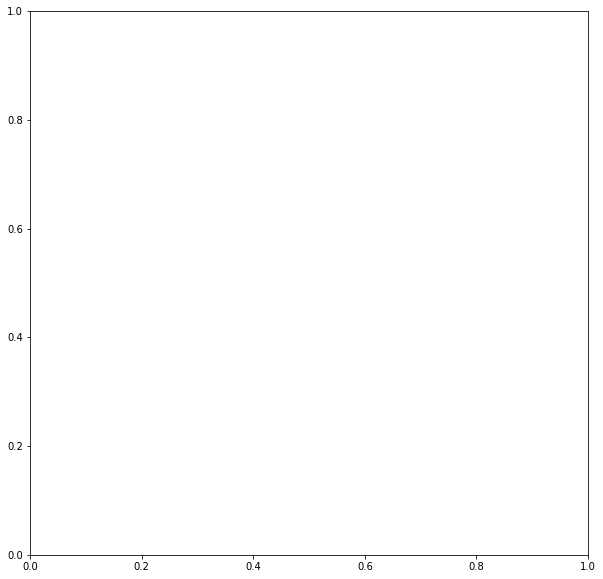

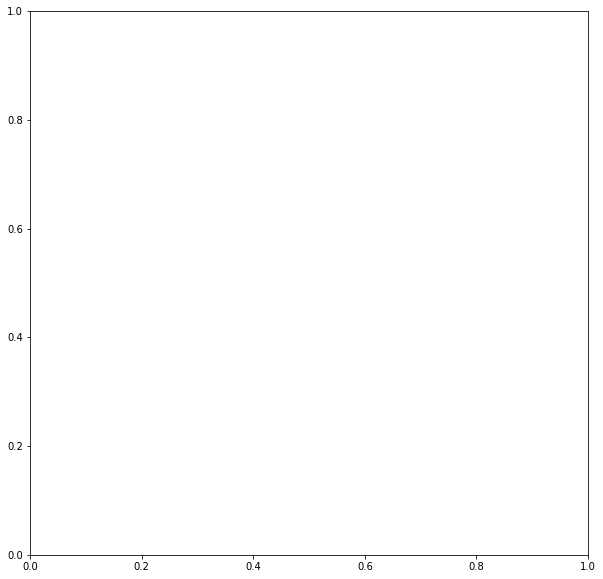

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.stats
from research_module import *
from copy import copy, deepcopy
from point import Point
from firewalls import *
from paritition import *
from plot import *


fig, ax = plt.subplots(figsize=(10, 10))
fig2, ax2 = plt.subplots(figsize=(10, 10))

connect_distance = 1
num_of_clusters = 3

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Preparing the poisson distribution pibts
# Simulation window parameters
xMin = 0
xMax = 20
yMin = 0
yMax = 20
xDelta = xMax-xMin
yDelta = yMax-yMin  # rectangle dimensions
areaTotal = xDelta*yDelta

lambda0 = 1
numbPoints = (scipy.stats.poisson(lambda0*areaTotal).rvs())
# np.save('point.npy',numbPoints)
# numbPoints = np.load('point.npy', allow_pickle=True)

x = np.random.uniform(size=numbPoints, low=xMin, high=xMax)
# np.save('x.npy',x)
# x = np.load('x.npy', allow_pickle=True)

y = np.random.uniform(size=numbPoints, low=yMin, high=yMax)
# np.save('y.npy',y)
# y = np.load('y.npy', allow_pickle=True)


### Assign the groups

This is dont through `k_means_constrained` within, the constraint is that each `Group` should be within 10% of the equal cut


In [102]:
groups_ = divide_even_clusters(x, y, num_of_clusters)

# groups_ = np.load('test.npy', allow_pickle=True)


### Prepare the `Point` objects and `Group` objects


In [103]:
array_of_points = []

for i in range(numbPoints):
    """
    The last index of the point object indecates the state of the point:
    0: Firewall
    1: Normal 
    2: Protected --> protects itself and it's edges (not a firewall) <---- this is used in the second approach of firewalls
    """
    array_of_points.append(Point(groups_[i], i, x[i], y[i], 1, 0))

array_of_groups = get_cluster_points(num_of_clusters, array_of_points)


### Prepare the edge matrix

if `p1` and `p2` are connected ( they are `connect_distance` or less apart) then `edge_matrix[p1][p2] = 1` )


In [104]:
edge_matrix = form_edge_matrix(array_of_points, connect_distance)


#### This updates the `Group` objects

Updates which points belong to which group, and updates their `group.points` & `group.outerPoints`


In [105]:
for group in array_of_groups:
    group.find_connected_groups()


array_of_groups[0].outerPoints


{(4, 7), (8, 10), (8, 9), (9, 10), (9, 14)}

In [106]:
all_points = {
    i for points in array_of_groups for p in points.points for i in p.connected_points}
c_id = 0
seen_points = set()
cluster_sizes = {}
cluster_content = {}


def dfs(point, c_id):
    for p in point.connected_points:
        if p in seen_points:
            continue
        seen_points.add(p)
        cluster_content[c_id].add(p)
        cluster_sizes[c_id] += 1
        dfs(p, c_id)


for p in all_points:
    cluster_sizes[c_id] = 0
    cluster_content[c_id] = set()
    dfs(p, c_id)
    c_id += 1


In [107]:
upper_bound = int((numbPoints/num_of_clusters)*1.1)
{k: v for k, v in cluster_sizes.items() if v > upper_bound}


{}

##### Plot the graph `(only k_means at this stage)`


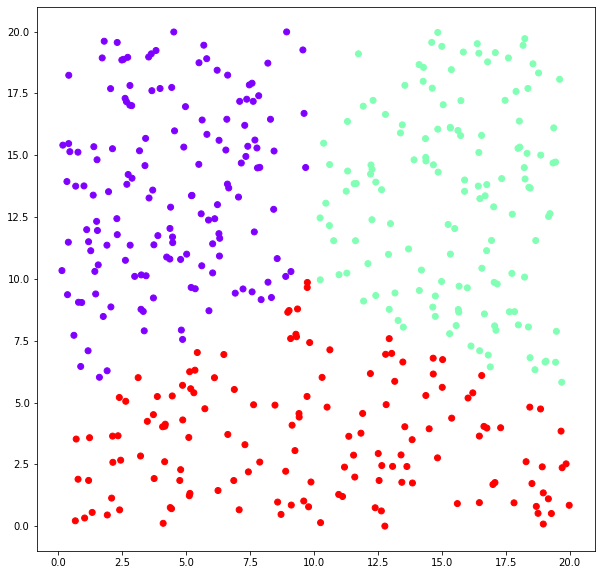

In [108]:

ax.clear()

plot_points(ax, x, y, groups_, array_of_groups)
# plot_edges(ax, array_of_groups)
# plot_firewalls(ax, array_of_groups, protect='self')

# plot_points_plotly(x, y, groups_, array_of_groups)
# # plot_firewalls_plotly(fig, array_of_groups, protect='self')

# px.scatter(x = x, y = y, color = groups_, width=800, height=800)

# # plot_borders(ax, xMax, xMin, yMax, yMin)
fig


### Multiway partitioning


Read the paper on wether I should prioritize the changed sets 

In [109]:
# %reload_ext autoreload

# i = 0
# while i < num_of_clusters:
#     startAgain = False
#     for group in array_of_groups[i].connectedGroup:
#         indicator = two_way(
#             array_of_groups[group], array_of_groups[i], groups_)
#         if indicator > 0:
#             print(array_of_groups[i].name, array_of_groups[group].name)
#             startAgain = True
#             array_of_groups[i].find_connected_groups()
#             array_of_groups[group].find_connected_groups()

#     i = 0 if startAgain else i + 1

%reload_ext autoreload
OUTPUT_PATH = 'output/'
queue = [[group1.name, group2]
         for group1 in array_of_groups for group2 in array_of_groups[group1.name].connectedGroup]


for group1, group2 in queue:
    indicator = two_way(
        array_of_groups[group1], array_of_groups[group2], groups_)
    if indicator > 0:
        ax2.clear() 
        plot_edges(ax2, array_of_groups)
        plot_points(ax2, x, y, groups_, array_of_groups)
        fig2.savefig(f'{OUTPUT_PATH}/{group1}_{group2}.png')
        queue += [[group1, group3] for group3 in array_of_groups[group1].connectedGroup
                  ] + [[group2, group3] for group3 in array_of_groups[group2].connectedGroup]
        array_of_groups[group1].find_connected_groups()
        array_of_groups[group2].find_connected_groups()


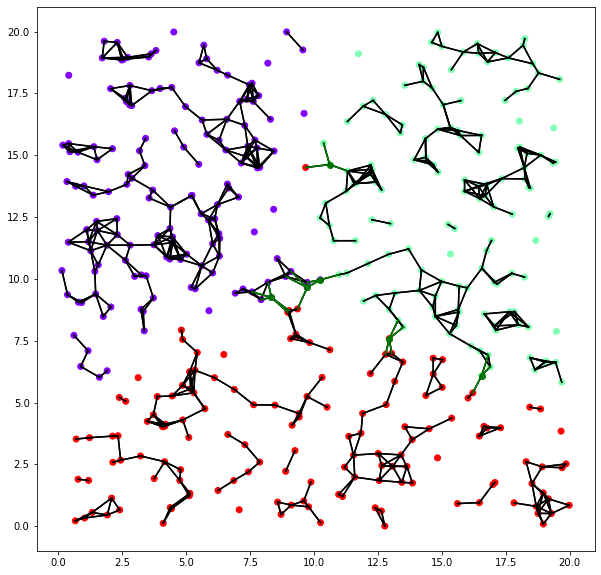

In [110]:
ax2.clear()


plot_points(ax2, x, y, groups_, array_of_groups)
plot_edges(ax2, array_of_groups)
plot_firewalls(ax2, array_of_groups, protect='self')
# plot_borders(ax2, xMax, xMin, yMax, yMin)
fig2


consider removing, no longer use edge matrix


In [111]:
edgeMatrixCopy = deepcopy(edge_matrix)


### One-way partitioning `our variation`


In [116]:
# %reload_ext autoreload
# for group in array_of_groups:
#     group.find_connected_groups()
# # one point interchange
# i = j = 0
# while i < num_of_clusters and j < 10:
#     startAgain = False
#     for group in array_of_groups[i].connectedGroup:
#         indicator = one_way_partioning_enhanced(
#             array_of_groups[i], array_of_groups[group], groups_, numbPoints/num_of_clusters, 0.1)
#         if indicator > 0:
#             startAgain = True
#         array_of_groups[i].find_connected_groups()
#         array_of_groups[group].find_connected_groups()
#     i = 0 if startAgain else i + 1
#     j += 1

import os


OUTPUT_PATH = 'output2/'
for f in os.listdir(OUTPUT_PATH):
    os.remove(os.path.join(OUTPUT_PATH, f))


queue = [[group1.name, group2]
         for group1 in array_of_groups for group2 in array_of_groups[group1.name].connectedGroup]


for group1, group2 in queue:
    print(group1, group2)
    indicator = single_way(
        array_of_groups[group1], array_of_groups[group2], groups_, numbPoints/num_of_clusters)
    if indicator > 0:
        ax2.clear() 
        plot_edges(ax2, array_of_groups)
        plot_points(ax2, x, y, groups_, array_of_groups)
        fig2.savefig(f'{OUTPUT_PATH}/{group1}_{group2}.png')
        queue += [[group1, group3] for group3 in array_of_groups[group1].connectedGroup
                  ] + [[group2, group3] for group3 in array_of_groups[group2].connectedGroup]
        array_of_groups[group1].find_connected_groups()
        array_of_groups[group2].find_connected_groups()


0 1
1 0
1 2
2 1
1 0
1 2
0 1
0 1
1 0
1 2
0 1
1 0
1 2
1 0
1 2
0 1
0 1
1 0
1 2
1 0
1 2
0 1
1 0
1 2
0 1
0 1
1 0
1 2
0 1
1 0
1 2
1 0
1 2
0 1
1 0
1 2
0 1
0 1
1 0
1 2
1 0
1 2
0 1
0 1
1 0
1 2
0 1
1 0
1 2
1 0
1 2
0 1
0 1
1 0
1 2
1 0
1 2
0 1
1 0
1 2
0 1
0 1
1 0
1 2
1 0
1 2
0 1
0 1
1 0
1 2
0 1
1 0
1 2
1 0
1 2
0 1
1 0
1 2
0 1
0 1
1 0
1 2
0 1
1 0
1 2
1 0
1 2
0 1
0 1
1 0
1 2
1 0
1 2
0 1
1 0
1 2
0 1
0 1
1 0
1 2
0 1
1 0
1 2
1 0
1 2
0 1
1 0
1 2
0 1
0 1
1 0
1 2
1 0
1 2
0 1
0 1
1 0
1 2
0 1
1 0
1 2
1 0
1 2
0 1
1 0
1 2
0 1
0 1
1 0
1 2
0 1
1 0
1 2
1 0
1 2
0 1
0 1
1 0
1 2
1 0
1 2
0 1
1 0
1 2
0 1
0 1
1 0
1 2
1 0
1 2
0 1
0 1
1 0
1 2
0 1
1 0
1 2
1 0
1 2
0 1
0 1
1 0
1 2
1 0
1 2
0 1
1 0
1 2
0 1
0 1
1 0
1 2
0 1
1 0
1 2
1 0
1 2
0 1
1 0
1 2
0 1
0 1
1 0
1 2
1 0
1 2
0 1
0 1
1 0
1 2
0 1
1 0
1 2
1 0
1 2
0 1
0 1
1 0
1 2
1 0
1 2
0 1
1 0
1 2
0 1
0 1
1 0
1 2
1 0
1 2
0 1
0 1
1 0
1 2
0 1
1 0
1 2
1 0
1 2
0 1
1 0
1 2
0 1
0 1
1 0
1 2
0 1


KeyboardInterrupt: 

##### Plot the graph

`effects: multiway partitioning + oneway paritioning`


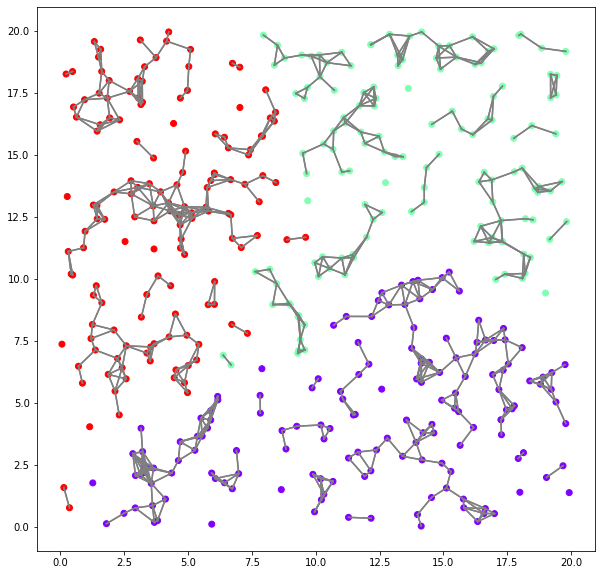

In [ ]:
%reload_ext autoreload

ax2.clear()


plot_points(ax2, x, y, groups_, array_of_groups)
plot_edges(ax2, array_of_groups, 'grey')
# plot_firewalls(ax2, array_of_groups, protect='self')
# plot_borders(ax2, xMax, xMin, yMax, yMin)

fig2


group_name: 0, #points, 153 dif_ori_cut: -9, connected_groups set()
group_name: 1, #points, 137 dif_ori_cut: 7, connected_groups set()
group_name: 2, #points, 143 dif_ori_cut: 1, connected_groups set()
433 158 129


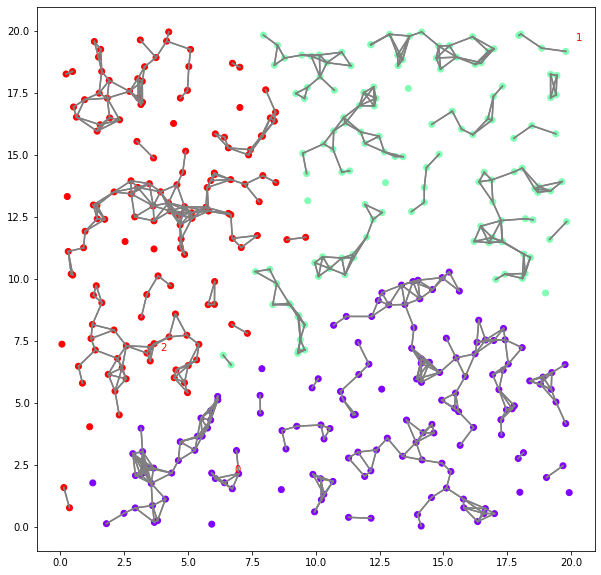

In [ ]:
# for group in array_of_groups:
#     if group.name == 1:
#         print(group.outerPoints)
%reload_ext autoreload
for group in array_of_groups:
    group.find_connected_groups()

for group in array_of_groups:
    x_ = list(group.points)[floor(len(group.points)/2)].x
    y_ = list(group.points)[floor(len(group.points)/2)].y
    print('group_name: {}, #points, {} dif_ori_cut: {}, connected_groups {}'.format(group.name, len(group.points), (int(numbPoints /
          num_of_clusters) - len(group.points)), (group.connectedGroup)))
    ax2.annotate(f'{group.name}', xy=(x_, y_), color='red',
                 xytext=(10, 10), textcoords="offset points")

print(numbPoints, int(int(numbPoints/num_of_clusters)*1.1),
      int((numbPoints/num_of_clusters)*0.9))

fig2


TODO: FIX BISECTION AND RELOCATE FILES AND FUNCTIONS